In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from PIL import Image
import torch.optim as optim
import gc
from tqdm import tqdm

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Function to free up CUDA memory
def free_cuda_memory():
    torch.cuda.empty_cache()
    gc.collect()


In [5]:
# Dataset and Dataloader
class SuperResolutionDataset(Dataset):
    def __init__(self, high_res_image_dir, csv_file=None, image_data=None, transform=None):
        if image_data is not None:
            self.image_data = image_data
        elif csv_file is not None:
            self.image_data = pd.read_csv(csv_file)
        self.transform = transform
        self.blurTransform = transforms.Compose([
            transforms.Resize((96, 96)),
        ])
        self.csv_file = csv_file
        self.high_res_image_dir = high_res_image_dir

        if len(self.image_data) == 0:
            raise ValueError(f"No image files found in CSV file: {csv_file}")
        
        print(f"Found {len(self.image_data)} image pairs.")

    def __len__(self):
        return len(self.image_data)
    
    def __getitem__(self, index):
        hr_image_path = self.image_data.iloc[index, 1]

        # add image path and convert it to RGB
        hr_img = Image.open(self.high_res_image_dir + hr_image_path).convert('RGB')

        
        # apply transform for both images
        if self.transform:
            hr_img = self.transform(hr_img)
        if self.blurTransform:
            lr_img = self.blurTransform(hr_img)
        return lr_img, hr_img


In [6]:
# define resize and transform
transform = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.ToTensor(),
])

img_set_path = "image_dataset/Image Super Resolution - Unsplash/"

# load and apply transform to more images
img_dataset = SuperResolutionDataset(csv_file=img_set_path + "image_data.csv",
#                                      low_res_image_dir=img_set_path + "/low res/",
                                     high_res_image_dir=img_set_path + "/high res/",
                                     transform=transform)

# Use more images
train_loader = DataLoader(img_dataset, batch_size=3, shuffle=True)

Found 3762 image pairs.


In [7]:
# Function to show lowres and high res images side by side
def show_tensorpair(tensor_pair):
    # convert to numpy for display
    lr_img = tensor_pair[0].cpu().numpy()
    hr_img = tensor_pair[1].cpu().numpy()
    print(lr_img.shape)
    print(hr_img.shape)
    # transpose the image reording the dimension from tensor to matplotlib use
    lr_img = lr_img.transpose(1, 2, 0)
    hr_img = hr_img.transpose(1, 2, 0)

    # display images using subplot
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].imshow(lr_img, cmap='gray')
    axs[0].set_title('Low-res Image')
    axs[0].axis('off')
    axs[1].imshow(hr_img, cmap='gray')
    axs[1].set_title('High-res Image')
    axs[1].axis('off')
    
    plt.show()


(3, 96, 96)
(3, 384, 384)


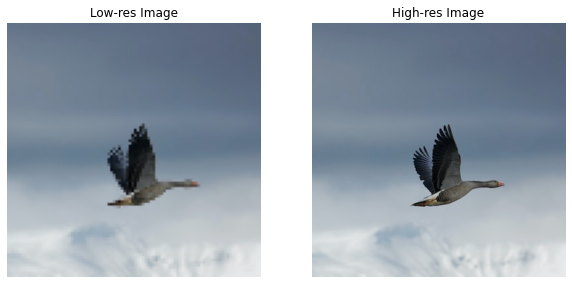

In [8]:
# Display the single sample image
show_tensorpair(img_dataset[40])

In [9]:
low_res_dir = 'super_res2/low_res_images'
high_res_dir = 'super_res2/high_res_images'
os.makedirs(low_res_dir, exist_ok=True)
os.makedirs(high_res_dir, exist_ok=True)


In [10]:

def save_images(train_loader, low_res_dir, high_res_dir):
    files = []
    num = 1
    for batch_idx, (low_res, high_res) in enumerate(train_loader):
        for i in range(low_res.size(0)):
            # Define file names
            low_res_file_name = f'{num}.jpg'
            high_res_file_name = f'{num}.jpg'
            
            low_res_file_path = os.path.join(low_res_dir, low_res_file_name)
            high_res_file_path = os.path.join(high_res_dir, high_res_file_name)
            
            save_image(low_res[i], low_res_file_path)
            save_image(high_res[i], high_res_file_path)
            
            files.append({'low_res_file': low_res_file_name, 'high_res_file': high_res_file_name})

                
            num+=1
    df = pd.DataFrame(files)
    return df

images_df = save_images(train_loader, low_res_dir, high_res_dir)

In [11]:
images_df.head(5)

,low_res_file,high_res_file
0,1.jpg,1.jpg
1,2.jpg,2.jpg
2,3.jpg,3.jpg
3,4.jpg,4.jpg
4,5.jpg,5.jpg


In [13]:
images_df.to_csv('super_res2/super_res.csv', index=False)


In [14]:
len(images_df)

3762